**Set environment**

In [1]:
### basic
import sys
sys.path.append('../')
from config_sing import *

### specific tools
from collections import defaultdict
from functools import reduce
import itertools as it
import sqlite3
# https://stackoverflow.com/questions/49456158/integer-in-python-pandas-becomes-blob-binary-in-sqlite
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))

### file path of fragment database
fdiry = os.path.join(FD_RES, "KS91_K562_ASTARRseq", 'database')
fname = "fragment_astarr_gata1.db"
FPATH_DB_ASTARR = os.path.join(fdiry, fname)

fdiry = os.path.join(FD_RES, "Tewhey_K562_TileMPRA", 'database')
fname = "fragment_tilempra_gata1.db"
FPATH_DB_TMPRA = os.path.join(fdiry, fname)

FPATHS_DB = [FPATH_DB_ASTARR, FPATH_DB_TMPRA]

You are on Duke Server: Singularity: Proj ENCODE FCC
BASE DIRECTORY:     /mount/work
PATH OF SOURCE:     /mount/work/source
PATH OF EXECUTABLE: /mount/work/exe
PATH OF ANNOTATION: /mount/work/annotation
PATH OF PROJECT:    /mount/project
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc



In [2]:
!nvidia-smi

Tue Mar 29 15:17:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:13:00.0 Off |                  N/A |
| 38%   34C    P0     1W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
print(physical_devices)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from umap.parametric_umap import ParametricUMAP

## Stream annotations from TileMPRA database

```
Table: Annotation
#Rows in table: 2,300,625
#Fragments:        52,312
```

In [5]:
%%time

fpath_db = FPATH_DB_TMPRA
table = "Annotation"

with sqlite3.connect(fpath_db) as conn:
    ### query the fragment annotations
    cursor = conn.cursor()
    query  = """
        SELECT Ant.Fragment, Mtf.motif, Mtf.score
        FROM Annotation Ant
        JOIN Motif      Mtf 
        ON   Ant.binding = Mtf.binding
        """
    cursor = cursor.execute(query)
    #rows   = it.islice(cursor, 1000)
    rows = cursor
    
    ### summarize the motif annotation scores
    dct_ann = defaultdict(lambda: defaultdict(lambda: 0.0))
    for idx, row in enumerate(rows):
        if idx % 500000 == 0:
            print(f"#Progress: {idx}")
        frg, mtf, val      = row
        dct_ann[frg][mtf] += val

#Progress: 0
#Progress: 500000
#Progress: 1000000
#Progress: 1500000
#Progress: 2000000
CPU times: user 7.29 s, sys: 649 ms, total: 7.93 s
Wall time: 1min 22s


**Arrange into a dataframe**

In [6]:
### convert dict of dict into a table
dat_ant = pd.DataFrame.from_dict(dct_ann, orient="index").fillna(0)
dat_ant = dat_ant.add_prefix("Mtf_")
dat_ant.index.name = 'Fragment'

### show the table
print(dat_ant.shape)
dat_ant.head()

(52312, 272)


,Mtf_KLF/SP/2,Mtf_ZNF28,Mtf_FOX/4,Mtf_ZNF382,Mtf_ZNF136,Mtf_ZNF41,Mtf_IRF/1,Mtf_RUNX/2,Mtf_ZNF320,Mtf_HD/20,...,Mtf_BCL6/1,Mtf_MYB/4,Mtf_HD/1,Mtf_HIF,Mtf_ZNF306,Mtf_ZNF547,Mtf_ZNF713,Mtf_GMEB2/1,Mtf_HINFP1/2,Mtf_ZBED1
Fragment,,,,,,,,,,,,,,,,,,,,,
chrX_47786401_47786600,6.700100,15.9435,8.4743,24.6662,2.6078,7.1286,5.3024,8.9312,5.6607,7.8543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX_47786951_47787150,5.008633,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.1885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX_47787001_47787200,11.829133,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX_47787051_47787250,11.829133,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX_47787101_47787300,11.829133,0.0000,8.8403,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Project the annotation using UMAP and learn the projection

In [7]:
### init
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

### setup the embedder
embedder = ParametricUMAP(random_state=SEED, n_training_epochs=5)

/usr/local/lib/python3.6/dist-packages/umap/parametric_umap.py:150: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  tensorflow installation. Setting global_correlation_loss_weight to zero."


In [8]:
### convert the table to a numpy array
mat = dat_ant.to_numpy()
print(dat_ant.shape)
print(mat.shape)

(52312, 272)
(52312, 272)


In [9]:
%%time
embedding = embedder.fit_transform(mat)

Epoch 1/50
6383/6383 [==============================] - 23s 3ms/step - loss: 0.2331
Epoch 2/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.2069
Epoch 3/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1974
Epoch 4/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1915
Epoch 5/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1881
Epoch 6/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1852
Epoch 7/50
6383/6383 [==============================] - 22s 3ms/step - loss: 0.1832
Epoch 8/50
6383/6383 [==============================] - 22s 4ms/step - loss: 0.1818
Epoch 9/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1807
Epoch 10/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1797
Epoch 11/50
6383/6383 [==============================] - 23s 4ms/step - loss: 0.1788
Epoch 12/50
6383/6383 [==============================] - 23s 4ms/step - lo

{'loss': [0.233145073056221, 0.20689861476421356, 0.19736464321613312, 0.19153355062007904, 0.18811781704425812, 0.1851664036512375, 0.18323886394500732, 0.181797593832016, 0.18068088591098785, 0.17966172099113464, 0.17877963185310364, 0.17830733954906464, 0.17717628180980682, 0.1765294075012207, 0.1763153225183487, 0.175639808177948, 0.1750688999891281, 0.17465363442897797, 0.1743009239435196, 0.1740771234035492, 0.17385819554328918, 0.17377106845378876, 0.1734078973531723, 0.17296388745307922, 0.17274868488311768, 0.17248503863811493, 0.17246361076831818, 0.17216099798679352, 0.17193645238876343, 0.1720592975616455, 0.17166902124881744, 0.1719379425048828, 0.17151570320129395, 0.17092429101467133, 0.1714829057455063, 0.1710878163576126, 0.17096218466758728, 0.17082801461219788, 0.17088176310062408, 0.17081864178180695, 0.17055833339691162, 0.17081022262573242, 0.1704450100660324, 0.17027148604393005, 0.1703374832868576, 0.1701798290014267, 0.17018641531467438, 0.1700599640607834, 0.1

Text(0.5, 0, 'Epoch')

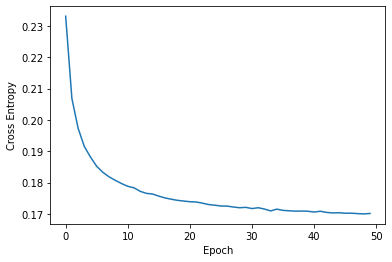

In [10]:
print(embedder._history)
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

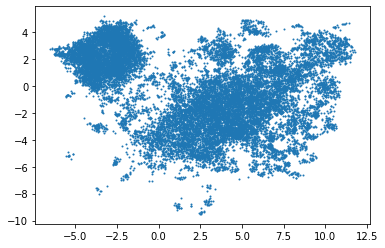

In [16]:
fig, ax = plt.subplots()
x = embedding[:20000,0]
y = embedding[:20000,1]
ax.scatter(x, y, s=1)

## Store

In [17]:
fdiry = os.path.join(FD_RES, "regulatory_landscape")
fname = "embedder_TileMPRA_trn_epochs_05.P"
fpath = os.path.join(fdiry, fname)
embedder.save(fpath)

INFO:tensorflow:Assets written to: /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/encoder/assets
Keras encoder model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/encoder
INFO:tensorflow:Assets written to: /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/parametric_model/assets
Keras full model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/parametric_model
Pickle of ParametricUMAP model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/model.pkl


In [19]:
fdiry = os.path.join(FD_RES, "regulatory_landscape")
fname = "dat_annot_TileMPRA.csv"
fpath = os.path.join(fdiry, fname)
dat_ant.to_csv(fpath)

In [9]:
embedding = embedder.fit_transform(mat)

Epoch 1/10
304/304 [==============================] - 2s 3ms/step - loss: 0.6027
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5795
Epoch 3/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5680
Epoch 4/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5776
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5707
Epoch 6/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5897
Epoch 7/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5754
Epoch 8/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5778
Epoch 9/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5781
Epoch 10/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5700


{'loss': [0.6026752591133118, 0.57953941822052, 0.5679945349693298, 0.5776426196098328, 0.5707141160964966, 0.5897448658943176, 0.5753776431083679, 0.5777857303619385, 0.5781247615814209, 0.5700395107269287]}


Text(0.5, 0, 'Epoch')

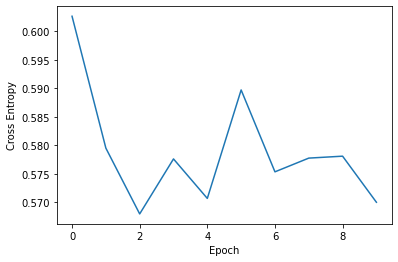

In [10]:
print(embedder._history)
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

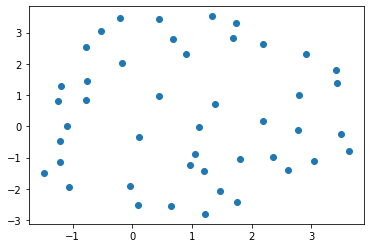

In [11]:
fig, ax = plt.subplots()
x = embedding[:,0]
y = embedding[:,1]
ax.scatter(x, y)

-----

In [12]:
embedding = embedder.fit_transform(mat)

Epoch 1/10
304/304 [==============================] - 36s 2ms/step - loss: 0.6250
Epoch 2/10
304/304 [==============================] - 1s 2ms/step - loss: 0.6027
Epoch 3/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5839
Epoch 4/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5823
Epoch 5/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5809
Epoch 6/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5774
Epoch 7/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5744
Epoch 8/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5787
Epoch 9/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5803
Epoch 10/10
304/304 [==============================] - 1s 2ms/step - loss: 0.5826


{'loss': [0.6249756813049316, 0.6027253866195679, 0.5839242935180664, 0.5823066234588623, 0.5809210538864136, 0.577443540096283, 0.5744251012802124, 0.5786588788032532, 0.5802567601203918, 0.5825533866882324]}


Text(0.5, 0, 'Epoch')

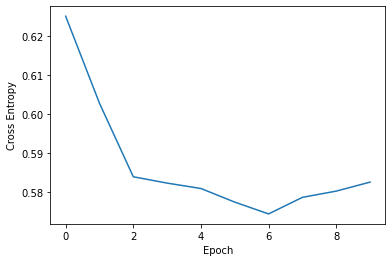

In [13]:
print(embedder._history)
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

In [14]:
type(embedding)

numpy.ndarray

In [16]:
embedding.shape

(45, 2)

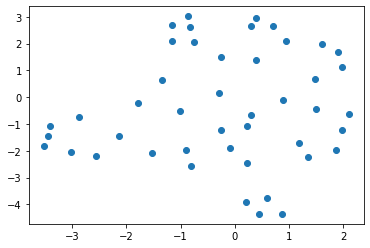

In [17]:
fig, ax = plt.subplots()
x = embedding[:,0]
y = embedding[:,1]
ax.scatter(x, y)

In [19]:
embedder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 153)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               15400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 35,802
Trainable params: 35,802
Non-trainable params: 0
_________________________________________________________________


In [22]:
fdiry = os.path.join(FD_RES, "regulatory_landscape")
fname = "embedder_TileMPRA_n_training_epochs.P"
fpath = os.path.join(fdiry, fname)
embedder.save(fpath)

INFO:tensorflow:Assets written to: /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/encoder/assets
Keras encoder model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/encoder
INFO:tensorflow:Assets written to: /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/parametric_model/assets
Keras full model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/parametric_model
Pickle of ParametricUMAP model saved to /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/model.pkl


In [23]:
from umap.parametric_umap import load_ParametricUMAP

In [24]:
embedder_test = load_ParametricUMAP(fpath)
print(embedder_test)

Pickle of ParametricUMAP model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/model.pkl
Keras encoder model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/encoder
Keras full model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA.P/parametric_model
ParametricUMAP(batch_size=45, dims=[153], encoder=<keras.engine.sequential.Sequential object at 0x7fa259731978>, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fa2583946a0>, parametric_reconstruction_loss_fcn=<keras.losses.BinaryCrossentropy object at 0x7fa24c532ac8>)


In [26]:
tmp = embedder_test.transform(mat)
tmp.shape

(45, 2)

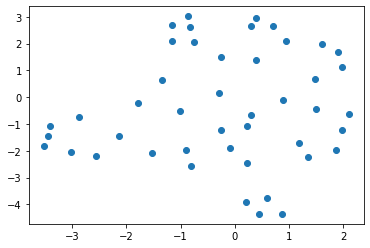

In [27]:
fig, ax = plt.subplots()
x = embedding[:,0]
y = embedding[:,1]
ax.scatter(x, y)

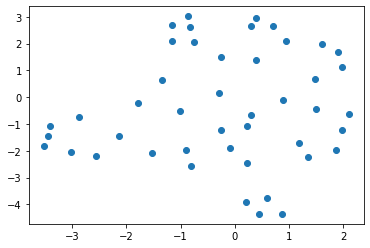

In [28]:
fig, ax = plt.subplots()
x = tmp[:,0]
y = tmp[:,1]
ax.scatter(x, y)